In [8]:
# Graph Magnitude Homology Ranks Calculations
#
# Original maple code by Simon Willerton
# Translation into Python+SAGE by James Cranch
# Furhter modifications by Simon Willerton
#
# Execute the file with sage's inbuilt python via:
#   sage -python < rational_graph_homology_arxiv.py
#
# The program just generates the chain groups and calculates the differentials
# then uses the ChainComplex package to calculate the homology.
#
# For a graph g the chain groups MC_{*,*}(g) break up in to subcomplexes
# MC_{*,l}^{s,t}(g) where l is the length of the chain and s and t are the initial
# and terminal vertices of the chain.
# So here generators[s,t,k,l] is a list of the degree k generators of such a chain group.
# Then differential[s,t,k,l] is a matrix giving the differential from generators[s,t,k,l]
# to generators[s,t,k-1,l].
# The homology of each subcomplex is calculated then the ranks are added together to give
# the required output.

import functools

import sage.all

from sage.graphs.graph import Graph
from sage.graphs.distances_all_pairs import distances_all_pairs
from sage.homology.chain_complex import ChainComplex
#from sage.misc.ascii_art import ascii_art

from sage.graphs.graph_generators import GraphGenerators
graphs = GraphGenerators()

from sage.matrix.constructor import Matrix as matrix

from sage.rings.integer_ring import IntegerRing
from sage.rings.rational_field import RationalField
#from sage.rings.finite_rings.constructor import FiniteField
#BaseRing = IntegerRing()
BaseRing = RationalField()
#BaseRing = FiniteField(2)





def magnitude_homology(g,lmax=6):

    kmax = lmax +1

    d = distances_all_pairs(g)

    # populate the generators recursively
    generators = dict(((s,t,k,l),[]) for s in g.vertices() for t in g.vertices() for k in range(kmax+2) for l in range(lmax+1))
    def add_generators(a,l,x):
        k = len(a)-1
        if k<=kmax and l<=lmax:
            generators[(a[0],a[len(a)-1],k,l)].append(a)
            for y in g.vertices():
                if x != y:
                    add_generators(a+[y],l+d[x][y],y)

    for x in g.vertices():
        add_generators([x],0,x)

    #print(generators)

    # number the generators, so as to produce differentials rapidly
    for s in g.vertices():
        for t in g.vertices():
            for l in range(lmax+1):
                for k in range(kmax+1):
                    generators[(s,t,k,l)] = dict((tuple(a),i) for (i,a) in enumerate(generators[(s,t,k,l)]))


    def differential(s,t,k,l):
        m = {}
        h = generators[(s,t,k-1,l)]
        for (a,i) in generators[(s,t,k,l)].items():
            for z in range(len(a)-2):
                if d[a[z]][a[z+1]] + d[a[z+1]][a[z+2]] == d[a[z]][a[z+2]]:
                    j = h[a[:z+1]+a[z+2:]]
                    if z%2:
                        m[(j,i)] = m.get((j,i),0) + 1
                    else:
                        m[(j,i)] = m.get((j,i),0) - 1
        return matrix(BaseRing, len(h), len(generators[(s,t,k,l)]), m)


    def chains(s,t,l):
        differentials = dict((k,differential(s,t,k,l)) for k in range(1,kmax+1) if generators[(s,t,k,l)] or generators[(s,t,k-1,l)])
        return ChainComplex(differentials, base_ring=BaseRing, degree=-1)


    def homology(s,t,l):
        ch = chains(s,t,l).homology(generators=True)
        ans = {}
        for (i, ch) in ch.items():
            h = sorted(generators[(s,t,i,l)].items(), key = lambda x: x[1])
            gr = sum([a[0] for a in ch]); gr = ZZ(0) if gr == 0 else gr
            gen = [[(coeff, h[k][0]) for (k, coeff) in filter(lambda x: not x[1] == 0, enumerate(a[1].vector(i).list()))] for a in ch]
            #print(h, gen)
            ans[i] = (gr, gen)
        return ans

    return dict(((s,t,l),homology(s,t,l)) for s in g.vertices() for t in g.vertices() for l in range(lmax+1))

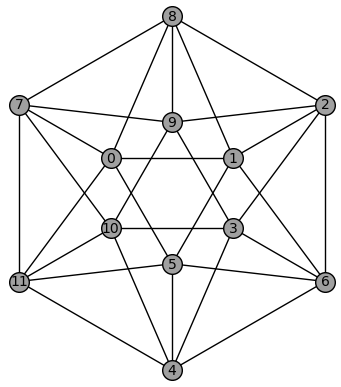

Icosahedral Graph
lmax = 4

 0:   12                         
 1:         60                   
 2:              132             
 3:                    144       
 4:                          144 

In [9]:

def figure_eight(m,n):
    g1 = graphs.CycleGraph(m)
    g2 = graphs.CycleGraph(n+m-2)
    return g1.union(g2)

def cyclic_wedge(m,n):
    g1 = graphs.CycleGraph(m)
    g2 = graphs.CycleGraph(n)
    g2.relabel(lambda i:i+m-1)
    return g1.union(g2)


# Pick a graph from the following list, or add your own


#g = DiGraph([(1,2),(2,3),(3,4),(4,1),(3,1)]); graph_name = "Test graph"
#g = graphs.CycleGraph(9); graph_name = "Cyc(9)"
#g = figure_eight(5,4); graph_name = 'Cyc(5) union Cyc(4) over an edge'
#g = cyclic_wedge(4,5)
#g = graphs.CompleteBipartiteGraph(4,3); graph_name='C(4,3)'
#g = graphs.RandomGNP(5,0.7)
#g = graphs.DodecahedralGraph(); graph_name = 'Dodecahedral Graph'
#g = graphs.HexahedralGraph(); graph_name = 'Hexecahedral Graph'
#g = graphs.OctahedralGraph(); graph_name = 'Octahedral Graph'
g = graphs.IcosahedralGraph(); graph_name = 'Icosahedral Graph'
#g = graphs.MoebiusKantorGraph(); graph_name = 'Moebius Kantor Graph'
#g = graphs.PappusGraph(); graph_name = 'Pappus Graph'
#g = graphs.HeawoodGraph(); graph_name = 'Heawood Graph'
#g = graphs.PetersenGraph(); graph_name='Petersen Graph'
#g = Graph({0:[1,2,3,4,5], 1:[0,2,3,4,5], 2:[0,1,3,4,5], 3:[0,1,2], 4:[0,1,2], 5:[0,1,2]})
#g = Graph({0:[1,5],1:[0,2,4,5],2:[1,3,4],3:[2,4],4:[1,2,3,5],5:[1,4,0]}); graph_name = '{0:[1,5],1:[0,2,4,5],2:[1,3,4],3:[2,4],4:[1,2,3,5],5:[1,4,0]'
#g = Graph({0:[1,4,5],1:[0,2,4],2:[1,3,4],3:[2,4],4:[0,1,2,3,5],5:[4,0]}); graph_name = '0:[1,4,5],1:[0,2,4],2:[1,3,4],3:[2,4],4:[0,1,2,3,5],5:[4,0]'
#g = graphs.CompleteMultipartiteGraph([3,3,3,3,3]); graph_name = "C(3,3,3,3,3)"
#h = graphs.CycleGraph(5)
#h = graphs.PetersenGraph()
#k = graphs.CycleGraph(5)
#k = graphs.CompleteMultipartiteGraph([1])
#g = h.join(k); graph_name = "Cyc(5) + Cyc(5)"
#g = graphs.TutteCoxeterGraph(); graph_name = "Tutte Coxeter Graph"


g.show(vertex_color='#A0A0A0')

lmax = 4

print (graph_name)
print ('lmax = {0}'.format(lmax))

homology = magnitude_homology(g,lmax)

#print(homology, g)

total_rank = dict(((k,l),0) for k in range(0,lmax+1) for l in range(0, lmax+1))
total_generators = dict(((k,l), []) for k in range(0,lmax+1) for l in range(0, lmax+1))

for s in g.vertices():
    for t in g.vertices():
        for l in range(lmax+1):
            for degree, (group, generators) in sorted(homology[s,t,l].items()): 
                total_rank[degree,l] += group.rank()
                total_generators[degree,l].append(generators)


for l in range(0,lmax+1):
    print ('')
    print ('{0:2d}:'.format(l), end=''),
    for k in range(0,lmax+1):
        if total_rank[k,l] != 0:
            print ('{0:5d} '.format(total_rank[k,l]), end=''),
        else:
            print ('      ', end='')



In [15]:
for l in range(0,lmax+1):
    print ('')
    print ('{0:2d}:'.format(l)),
    for k in range(0,lmax+1):
        if total_rank[k,l] != 0:
            print ('{0:2d}:'.format(k), end=''),
            print(*total_generators[k,l], sep='\n')


 0:
 0:[[(1, (0,))]]
[[(1, (1,))]]
[[(1, (2,))]]
[[(1, (3,))]]
[[(1, (4,))]]
[[(1, (5,))]]
[[(1, (6,))]]
[[(1, (7,))]]
[[(1, (8,))]]
[[(1, (9,))]]
[[(1, (10,))]]
[[(1, (11,))]]

 1:
 1:[[(1, (0, 1))]]
[[(1, (0, 5))]]
[[(1, (0, 7))]]
[[(1, (0, 8))]]
[[(1, (0, 11))]]
[[(1, (1, 0))]]
[[(1, (1, 2))]]
[[(1, (1, 5))]]
[[(1, (1, 6))]]
[[(1, (1, 8))]]
[[(1, (2, 1))]]
[[(1, (2, 3))]]
[[(1, (2, 6))]]
[[(1, (2, 8))]]
[[(1, (2, 9))]]
[[(1, (3, 2))]]
[[(1, (3, 4))]]
[[(1, (3, 6))]]
[[(1, (3, 9))]]
[[(1, (3, 10))]]
[[(1, (4, 3))]]
[[(1, (4, 5))]]
[[(1, (4, 6))]]
[[(1, (4, 10))]]
[[(1, (4, 11))]]
[[(1, (5, 0))]]
[[(1, (5, 1))]]
[[(1, (5, 4))]]
[[(1, (5, 6))]]
[[(1, (5, 11))]]
[[(1, (6, 1))]]
[[(1, (6, 2))]]
[[(1, (6, 3))]]
[[(1, (6, 4))]]
[[(1, (6, 5))]]
[[(1, (7, 0))]]
[[(1, (7, 8))]]
[[(1, (7, 9))]]
[[(1, (7, 10))]]
[[(1, (7, 11))]]
[[(1, (8, 0))]]
[[(1, (8, 1))]]
[[(1, (8, 2))]]
[[(1, (8, 7))]]
[[(1, (8, 9))]]
[[(1, (9, 2))]]
[[(1, (9, 3))]]
[[(1, (9, 7))]]
[[(1, (9, 8))]]
[[(1, (9, 10))]]
[[(1, 